In [ ]:
from riskyneuroarousal.utils.load_data import load_behavioral_data
from riskyneuroarousal.modeling.behavioral_models import (fit_model, 
                                                    negLL_ordinal, 
                                                    negLL_binary,
                                                    value_function,
                                                    inv_value_function, 
                                                    convert_subjective, 
                                                    negLL_ordinal_historybias,
                                                    negLL_EV)
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

Fitting regular model

In [2]:
# load data
df = load_behavioral_data()
# for sub in df, shift 1 based on accept and call in history
df['history'] = df.groupby('sub')['accept'].shift(1).fillna(0).astype(int)
df = df.query("RT > 0.2").reset_index()

In [3]:
model_params_info = {
    "EV_binary" : {
        "negLL": negLL_EV,
        "bounds": ((-50, 50), (0.1, 10)),
        "pars0": [-1, 1],
        "param_names": ["c", "sigma", "LL"],
    }, 
    "CPT_binary" : {
        "negLL": negLL_binary,
        "bounds": ((1, 1), (0, 15), (-50, 50), (0.1, 10)),
        "pars0": [1, 0.1, -1, 1],
        "param_names": ["alpha", "lambd", "c", "sigma", "LL"],
    },
    "CPT_ordinal_history" : {
        "negLL": negLL_ordinal_historybias,
        "bounds": ((1, 1), (0, 10), (0.1, None), (None, 0.1), (None, None), (0.1, 10), (-25, 25)),
        "pars0": [0.9, 1, 10, -2, 0.5, 1, 0],
        "param_names": ["alpha", "lambd", "a_1", "a_2", "c", "sigma", "delta", "LL"],
    },
}

In [6]:
model_params = {model_name : {"param_names" : [], 
                              "estimates" : [], 
                              "sub" : [], 
                              "condition" : []
                              }
                for model_name in model_params_info.keys()}

for model in model_params.keys():
    if model != "CPT_ordinal_history":
        continue
    for sub in df["sub"].unique():

        # Extract data for subject
        print(f"Fitting subject {sub}")
        sub_df = df.query(f"sub == {sub} & trial < 150 & trial > 30").reset_index(drop=True)
        condition = sub_df["condition"].unique()[0]

        # fit model
        pars, loss = fit_model(sub_df, 
                            model_params_info[model]["negLL"], 
                            model_params_info[model]["pars0"],
                            model_params_info[model]["bounds"], 
        )
        if pars is not None:
            model_params[model]["param_names"].extend(model_params_info[model]["param_names"])
            model_params[model]["estimates"].extend(pars)
            model_params[model]["estimates"].extend([loss])
            model_params[model]["sub"].extend([sub] * len(model_params_info[model]["param_names"]))
            model_params[model]["condition"].extend([condition] * len(model_params_info[model]["param_names"]))
            print(f"Subject {sub} fitted successfully!")

    # save parameters
    model_params[model] = pd.DataFrame(model_params[model])

Fitting subject 1
Subject 1 fitted successfully!
Fitting subject 2


KeyboardInterrupt: 

In [7]:
model_params

{'EV_binary': {'param_names': [], 'estimates': [], 'sub': [], 'condition': []},
 'CPT_binary': {'param_names': [],
  'estimates': [],
  'sub': [],
  'condition': []},
 'CPT_ordinal_history': {'param_names': ['alpha',
   'lambd',
   'a_1',
   'a_2',
   'c',
   'sigma',
   'delta',
   'LL'],
  'estimates': [np.float64(1.0),
   np.float64(1.4814397738993799),
   np.float64(13.27731430127515),
   np.float64(-4.539758239167361),
   np.float64(-3.2262932556574295),
   np.float64(2.333132380245602),
   np.float64(1.5820042132189416),
   34.72922173752236],
  'sub': [np.int64(1),
   np.int64(1),
   np.int64(1),
   np.int64(1),
   np.int64(1),
   np.int64(1),
   np.int64(1),
   np.int64(1)],
  'condition': ['equalIndifference',
   'equalIndifference',
   'equalIndifference',
   'equalIndifference',
   'equalIndifference',
   'equalIndifference',
   'equalIndifference',
   'equalIndifference']}}

In [5]:
model_params

{'EV_binary':   param_names  estimates  sub          condition
 0           c   0.280166    1  equalIndifference
 1       sigma   0.938256    1  equalIndifference
 2          LL   8.387898    1  equalIndifference,
 'CPT_binary':   param_names  estimates  sub          condition
 0       alpha   1.000000    1  equalIndifference
 1       lambd   0.894692    1  equalIndifference
 2           c   2.036272    1  equalIndifference
 3       sigma   1.745795    1  equalIndifference
 4          LL   8.154160    1  equalIndifference,
 'CPT_ordinal_history': {'param_names': [],
  'estimates': [],
  'sub': [],
  'condition': []}}

In [20]:
# Combine all model parameters into a single DataFrame
model_params = pd.concat(
    [df.assign(model=name) for name, df in model_params.items()],
    ignore_index=True
)

In [26]:
model_params.query("param_names == 'lambd'")

,param_names,estimates,sub,condition,model
325,lambd,0.100000,1,equalIndifference,CPT_binary
330,lambd,0.791693,2,equalRange,CPT_binary
335,lambd,0.100000,3,equalIndifference,CPT_binary
340,lambd,0.900239,4,equalRange,CPT_binary
345,lambd,0.100000,5,equalIndifference,CPT_binary
...,...,...,...,...,...
840,lambd,0.100000,119,equalIndifference,CPT_binary
845,lambd,1.106730,120,equalRange,CPT_binary
850,lambd,0.100000,121,equalIndifference,CPT_binary
855,lambd,0.100000,123,equalIndifference,CPT_binary


<Axes: xlabel='condition', ylabel='estimates'>

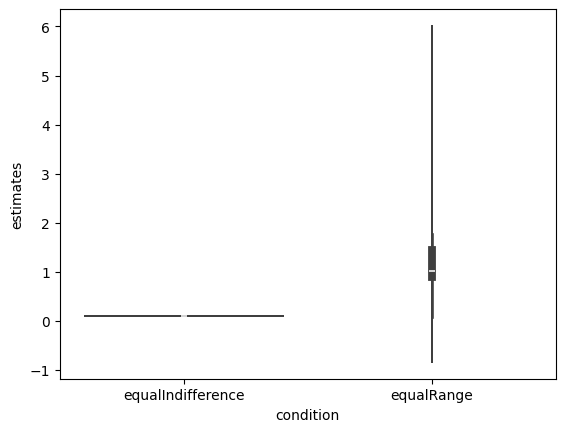

In [25]:
sns.violinplot(model_params.query("param_names == 'lambd'"), x = "condition", y = "estimates")

Fitting ordinal with history

Comparing estimates

In [30]:
subs_df = []
for sub in df["sub"].unique():
    params = model_params.query(f"sub == {sub} & model == 'CPT_ordinal_history'").reset_index().pivot(index = "sub", columns = "param_names", values = "estimates").reset_index()
    df2 = convert_subjective(df.query(f"sub == {sub}").reset_index(), params, model = "CPT_ordinal_history")
    subs_df.append(df2)
subs_df_CPTordinalhistory = pd.concat(subs_df, axis=0)

In [27]:
subs_df = []
for sub in df["sub"].unique():
    params = model_params.query(f"sub == {sub} & model == 'CPT_binary'").reset_index().pivot(index = "sub", columns = "param_names", values = "estimates").reset_index()
    df2 = convert_subjective(df.query(f"sub == {sub}").reset_index(), params, model = "CPT_binary")
    subs_df.append(df2)
subs_df_CPTbinary = pd.concat(subs_df, axis=0)

In [28]:
subs_df = []
for sub in df["sub"].unique():
    params = model_params.query(f"sub == {sub} & model == 'EV_binary'").reset_index().pivot(index = "sub", columns = "param_names", values = "estimates").reset_index()
    df2 = convert_subjective(df.query(f"sub == {sub}").reset_index(), params, model = "EV_binary")
    subs_df.append(df2)
subs_df_EVbinary = pd.concat(subs_df, axis=0)

In [29]:
# acc_CPTordinalhistory = np.mean(subs_df_CPTordinalhistory.query("trial >= 150")["accept"] == subs_df_CPTordinalhistory.query("trial >= 150")["accept_pred"])
acc_CPTbinary = np.mean(subs_df_CPTbinary.query("trial >= 150")["accept"] == subs_df_CPTbinary.query("trial >= 150")["accept_pred"])
acc_EVbinary = np.mean(subs_df_EVbinary.query("trial >= 150")["accept"] == subs_df_EVbinary.query("trial >= 150")["accept_pred"])
# print(f"Accuracy CPT ordinal history: {acc_CPTordinalhistory}")
print(f"Accuracy CPT binary: {acc_CPTbinary}")
print(f"Accuracy EV binary: {acc_EVbinary}")

Accuracy CPT binary: 0.7720934286212306
Accuracy EV binary: 0.896810179536343


In [43]:
# Normalize decision_value within each subject
subs_df_CPTordinalhistory["norm_decision_value"] = subs_df_CPTordinalhistory.groupby("sub")["decision_value"].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
subs_df_CPTbinary["norm_decision_value"] = subs_df_CPTbinary.groupby("sub")["decision_value"].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
subs_df_EVbinary["norm_decision_value"] = subs_df_EVbinary.groupby("sub")["decision_value"].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

Text(0, 0.5, 'CPT binary')

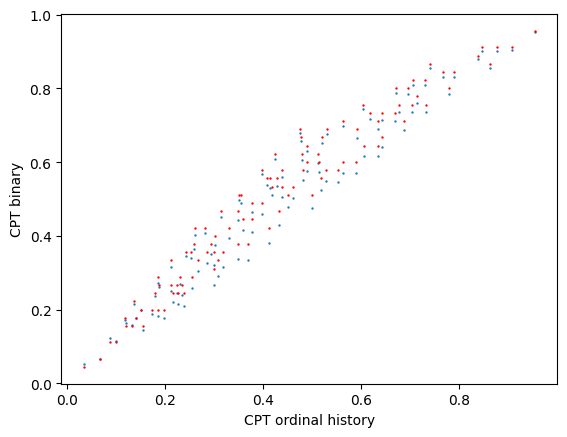

In [48]:
plt.scatter(subs_df_CPTordinalhistory.query("sub == 1 & trial >= 150")["norm_decision_value"],
            subs_df_CPTbinary.query("sub == 1 & trial >= 150")["norm_decision_value"], 
            s=0.5,)
plt.scatter(subs_df_CPTordinalhistory.query("sub == 1 & trial >= 150")["norm_decision_value"],
            subs_df_EVbinary.query("sub == 1 & trial >= 150")["norm_decision_value"], 
            s=0.5, color = "red")
plt.xlabel("CPT ordinal history")
plt.ylabel("CPT binary")

In [52]:
subs_df_CPTbinary["bin_evidence"] = pd.cut(subs_df_CPTbinary["norm_decision_value"], bins = [-0.01, 0.25, 0.5, 0.75, 1.01], labels = [0, 1/3, 2/3, 1])
subs_df_CPTordinalhistory["bin_evidence"] = pd.cut(subs_df_CPTordinalhistory["norm_decision_value"], bins = [-0.01, 0.25, 0.5, 0.75, 1.01], labels = [0, 1/3, 2/3, 1])
subs_df_EVbinary["bin_evidence"] = pd.cut(subs_df_EVbinary["norm_decision_value"], bins = [-0.01, 0.25, 0.5, 0.75, 1.01], labels = [0, 1/3, 2/3, 1])

<Axes: xlabel='bin_evidence', ylabel='RT'>

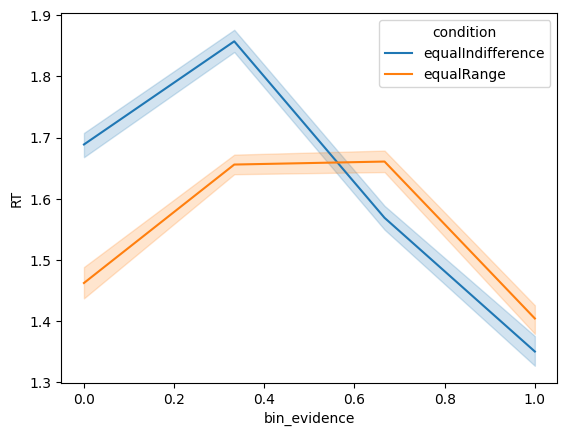

In [53]:
sns.lineplot(data = subs_df_CPTbinary, x = "bin_evidence", y = "RT", hue = "condition")

<Axes: xlabel='bin_evidence', ylabel='RT'>

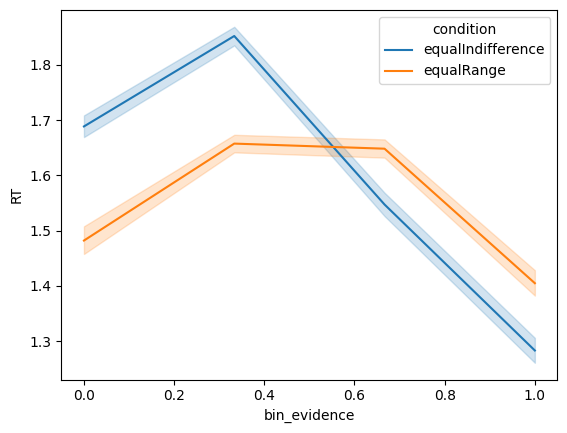

In [55]:
sns.lineplot(data = subs_df_CPTordinalhistory, x = "bin_evidence", y = "RT", hue = "condition")

<Axes: xlabel='bin_evidence', ylabel='RT'>

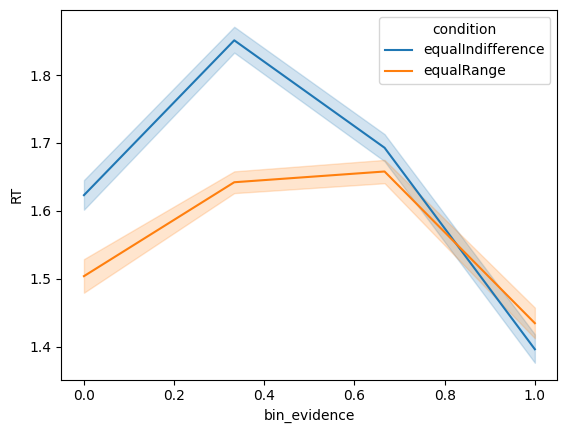

In [54]:
sns.lineplot(data = subs_df_EVbinary, x = "bin_evidence", y = "RT", hue = "condition")

In [ ]:
sns.lineplot(data = subs_df_CPTordinalhistory, x = "bin_evidence", y = "RT", hue = "condition")

In [23]:
subs_df_CPTordinalhistory["evidence"] = (subs_df_CPTordinalhistory["EV"]-2.5)/1.5
subs_df_CPTbinary["evidence"] = (subs_df_CPTbinary["EV"]-0.5)/0.5
subs_df_EVbinary["evidence"] = (subs_df_EVbinary["EV"]-0.5)/0.5

<Axes: xlabel='decision_value', ylabel='evidence'>

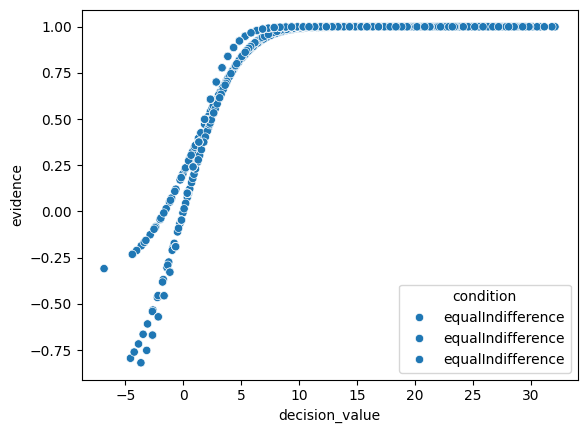

In [25]:
sns.scatterplot(data = subs_df_CPTordinalhistory, x = "decision_value", y = "evidence", hue = "condition")
sns.scatterplot(data = subs_df_CPTbinary, x = "decision_value", y = "evidence", hue = "condition")
sns.scatterplot(data = subs_df_EVbinary, x = "decision_value", y = "evidence", hue = "condition")

(-30.0, 30.0)

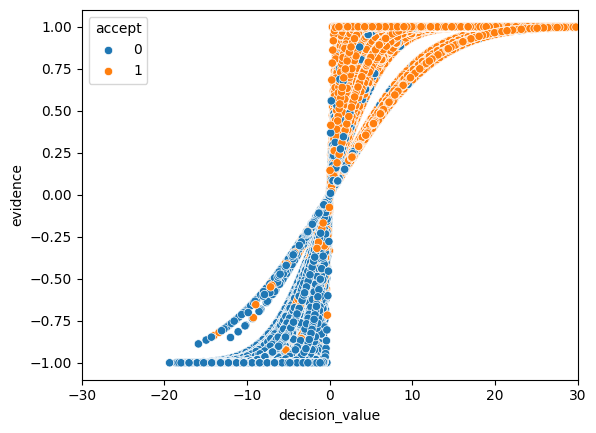

In [109]:
sns.scatterplot(data = subs_df_binary, x = "decision_value", y = "evidence", hue = "accept")
plt.xlim(-30, 30)

In [139]:
subs_df_binary["bin_evidence"] = pd.cut(subs_df_binary["evidence"], bins = [-1.01, -0.75, -0.25, 0.25, 0.75, 1.01], labels = [-1, -0.5, 0, 0.5, 1])
subs_df_ordinal["bin_evidence"] = pd.cut(subs_df_ordinal["evidence"], bins = [-1.01, -0.75, -0.25, 0.25, 0.75, 1.01], labels = [-1, -0.5, 0, 0.5, 1])

In [ ]:
df["EV"] = (df["gain"] - df["loss"])/2
df["bin_evidence"] = pd.cut(df["EV"], bins = [-1.01, -0.75, -0.25, 0.25, 0.75, 1.01], labels = [-1, -0.5, 0, 0.5, 1])

,index,sub,run,condition,gain,loss,RT,accept,response_int,participant_response,trial,history
0,0,1,1,equalIndifference,14,6,2.388,1,3.0,weakly_accept,1,0
1,1,1,1,equalIndifference,34,14,2.289,1,4.0,strongly_accept,2,1
2,2,1,1,equalIndifference,34,13,1.873,1,4.0,strongly_accept,3,1
3,3,1,1,equalIndifference,10,10,1.457,0,2.0,weakly_reject,4,1
4,4,1,1,equalIndifference,12,19,1.973,0,1.0,strongly_reject,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...
27438,27643,124,4,equalRange,7,14,1.235,0,1.0,strongly_reject,252,0
27439,27644,124,4,equalRange,5,9,1.236,0,1.0,strongly_reject,253,0
27440,27645,124,4,equalRange,5,15,1.030,0,1.0,strongly_reject,254,0
27441,27646,124,4,equalRange,12,18,1.029,0,1.0,strongly_reject,255,0


<Axes: xlabel='bin_evidence', ylabel='RT'>

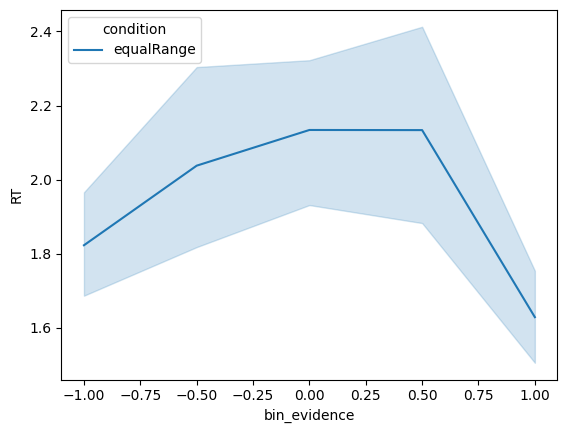

In [152]:
sns.lineplot(data = subs_df_binary.query("sub == 4"), x = "bin_evidence", y = "RT", hue = "condition")

<Axes: xlabel='bin_evidence', ylabel='RT'>

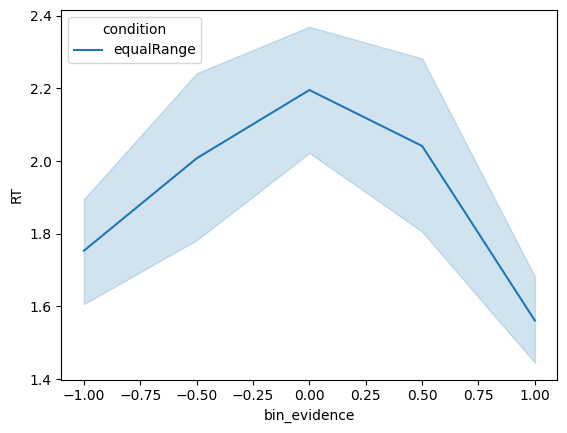

In [150]:
sns.lineplot(data = subs_df_ordinal.query("sub == 4"), x = "bin_evidence", y = "RT", hue = "condition")

In [ ]:
sns.scatterplot(data = subs_df_binary, x = "evidence", y = "RT", hue = "condition")

In [ ]:
np.int64(3): {'alpha': np.float64(0.9),
  'lambd': np.float64(0.5898308082342142),
  'c': np.float64(5.4223237279985605),
  'sigma': np.float64(3.8639029770003375)}

In [41]:
np.mean(df2["accept"] == df2["accept_pred"])

np.float64(0.9186991869918699)

In [97]:
params_df

,param_names,estimates,sub,condition
0,alpha,1.255954,2,equalRange
1,lambd,0.698280,2,equalRange
2,a_1,6.820177,2,equalRange
3,a_2,-4.792616,2,equalRange
4,c,4.749816,2,equalRange
5,sigma,4.357834,2,equalRange


In [98]:
{np.int64(2): {'alpha': np.float64(0.5940729079514315),
  'lambd': np.float64(0.7906874950881189),
  'c': np.float64(1.3129411938441538),
  'sigma': np.float64(0.9817765167751253)}}

{np.int64(2): {'alpha': np.float64(0.5940729079514315),
  'lambd': np.float64(0.7906874950881189),
  'c': np.float64(1.3129411938441538),
  'sigma': np.float64(0.9817765167751253)}}